<img src="https://i.imgur.com/mi9U6o5.png">

# Introduction 📝
🎯 **Goal:** To build algorithms to rate the complexity of reading passages for grade 3-12 classroom use. 

📖 **Data:** 
> **train.csv / test.csv** - the training and testing set
> - ```id``` - unique ID for excerpt
> - ```url_legal``` - URL of source 
> - ```license``` - license of source material 
> - ```excerpt``` - text to predict reading ease of
> - ```target``` - reading ease
> - ```standard_error``` - measure of spread of scores among multiple raters for each excerpt

📌 **Note:** ```url_legal```, ```license``` and ```standard error``` are blank in the test set.

🧪 **Evaluation metric:** Root Mean Squared Error (RMSE)
> $$RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big(\frac{y_i - \hat{y_i}}{\sigma_i}\Big)^2}}$$
> where 
> * $y_i$ : original value
> * $\hat{y_i}$ : predicted value
> * $n$ : number of rows in the test data

# Import libraries 📚

In [1]:
!pip install textstat
!pip install rich

import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import re
import nltk
import textstat
import time
import wandb
import rich
import spacy

from pandas import DataFrame
from matplotlib.lines import Line2D
from rich.console import Console
from rich import print
from rich.theme import Theme
from nltk.corpus import stopwords
from nltk import pos_tag
from collections import Counter
from wordcloud import WordCloud,STOPWORDS
from spacy import displacy
from nltk.tokenize import sent_tokenize, word_tokenize 
from sklearn.feature_extraction.text import CountVectorizer as CV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error as mse

nltk.download('stopwords')

     |████████████████████████████████| 99 kB 3.4 MB/s 
     |████████████████████████████████| 1.9 MB 34.0 MB/s 
     |████████████████████████████████| 203 kB 4.4 MB/s 
     |████████████████████████████████| 51 kB 4.9 MB/s 
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

<img src="https://camo.githubusercontent.com/dd842f7b0be57140e68b2ab9cb007992acd131c48284eaf6b1aca758bfea358b/68747470733a2f2f692e696d6775722e636f6d2f52557469567a482e706e67">

> I will be integrating W&B for visualizations and logging artifacts!
> 
> [CommonLit Project on W&B Dashboard](https://wandb.ai/ruchi798/commonlit?workspace=user-ruchi798) 🏋️‍♀️
> 
> - To get the API key, an account is to be created on the [website](https://wandb.ai/site) first.
> - Next, use secrets to use API Keys more securely 🤫

In [2]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
api_key = user_secrets.get_secret("wandb-api")

os.environ["WANDB_SILENT"] = "true"
! wandb login $api_key

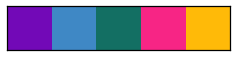

In [3]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

def custom_palette(custom_colors):
    customPalette = sns.set_palette(sns.color_palette(custom_colors))
    sns.palplot(sns.color_palette(custom_colors),size=0.8)
    plt.tick_params(axis='both', labelsize=0, length = 0)

palette = ["#7209B7","#3F88C5","#136F63","#F72585","#FFBA08"]
palette2 = sns.diverging_palette(120, 220, n=20)
custom_palette(palette)

custom_theme = Theme({
    "info" : "italic bold cyan",
    "warning": "italic bold magenta",
    "danger": "bold blue"
})

console = Console(theme=custom_theme)

In [4]:
train_df = pd.read_csv("../input/commonlitreadabilityprize/train.csv")
test_df = pd.read_csv("../input/commonlitreadabilityprize/test.csv")

In [5]:
train_df.head()

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845


In [6]:
test_df.head()

,id,url_legal,license,excerpt
0,c0f722661,NaN,NaN,My hope lay in Jack's promise that he would ke...
1,f0953f0a5,NaN,NaN,Dotty continued to go to Mrs. Gray's every nig...
2,0df072751,NaN,NaN,It was a bright and cheerful scene that greete...
3,04caf4e0c,https://en.wikipedia.org/wiki/Cell_division,CC BY-SA 3.0,Cell division is the process by which a parent...
4,0e63f8bea,https://en.wikipedia.org/wiki/Debugging,CC BY-SA 3.0,Debugging is the process of finding and resolv...


In [7]:
train_df.nunique()

id                2834
url_legal          667
license             15
excerpt           2834
target            2834
standard_error    2834
dtype: int64

# Missing values🔮

Here I have used a viz module called [missingno](https://pypi.org/project/missingno/) to visualize missing values in the training set.

We don't have any missing values in the columns of our interest, i.e., ```excerpt```, ```target``` and ```standard_error```!

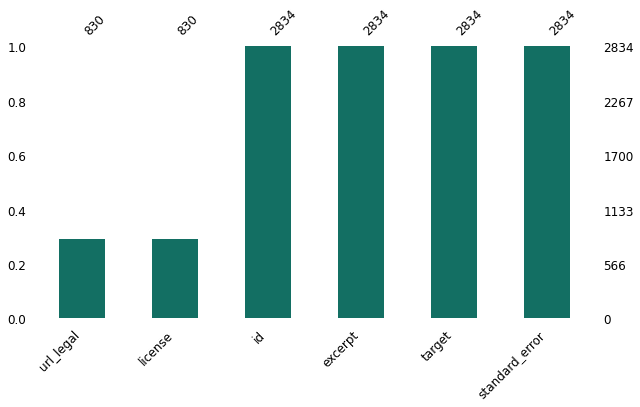

In [8]:
msno.bar(train_df,color=palette[2], sort="ascending", figsize=(10,5), fontsize=12)
plt.show()

# Pre-processing excerpt ✂️

It's important to preprocess the excerpt before we proceed further!

In [9]:
excerpt1 = train_df['excerpt'].min()
console.print("Before preprocessing: ",style="info")
console.print(excerpt1,style='warning')

e = re.sub("[^a-zA-Z]", " ", excerpt1)
e = e.lower()
        
e = nltk.word_tokenize(e)
        
e = [word for word in e if not word in set(stopwords.words("english"))]
        
lemma = nltk.WordNetLemmatizer()
e = [lemma.lemmatize(word) for word in e]
e=" ".join(e)
console.print("After preprocessing: ",style="info")
console.print(e,style='warning')

Before preprocessing: 

"'Morning, Jeeves," I said.
"Good morning, sir," said Jeeves. He put the good old cup of tea softly on the table by my 
bed, and I took a refreshing sip. Just right, as usual. Not too hot, not too sweet, not too 
weak, not too strong, not too much milk, and not a drop spilled in the saucer. A most amazing
cove, Jeeves. So dashed competent in every respect. I've said it before, and I'll say it 
again. I mean to say, take just one small instance. Every other valet I've ever had used to 
barge into my room in the morning while I was still asleep, causing much misery: but Jeeves 
seems to know when I'm awake by a sort of telepathy. He always floats in with the cup exactly
two minutes after I come to life. Makes a deuce of a lot of difference to a fellow's day.
"How's the weather, Jeeves?" 
"Exceptionally clement, sir."
"Anything in the papers?"
"Some slight friction threatening in the Balkans, sir. Otherwise, nothing."

After preprocessing: 

morning jeeves said good morning sir said jeeves put good old cup tea softly table bed took 
refreshing sip right usual hot sweet weak strong much milk drop spilled saucer amazing cove 
jeeves dashed competent every respect said say mean say take one small instance every valet 
ever used barge room morning still asleep causing much misery jeeves seems know awake sort 
telepathy always float cup exactly two minute come life make deuce lot difference fellow day 
weather jeeves exceptionally clement sir anything paper slight friction threatening balkan 
sir otherwise nothing

In [10]:
#====== Preprocessing function ======
def preprocess(data):
    excerpt_processed=[]
    for e in data['excerpt']:
        
        # find alphabets
        e = re.sub("[^a-zA-Z]", " ", e)
        
        # convert to lower case
        e = e.lower()
        
        # tokenize words
        e = nltk.word_tokenize(e)
        
        # remove stopwords
        e = [word for word in e if not word in set(stopwords.words("english"))]
        
        # lemmatization
        lemma = nltk.WordNetLemmatizer()
        e = [lemma.lemmatize(word) for word in e]
        e=" ".join(e)
        
        excerpt_processed.append(e)
        
    return excerpt_processed 

Logging the preprocessed dataset as an **artifact** 🏋️‍♀️

In [11]:
# train_df["excerpt_preprocessed"] = preprocess(train_df)
# test_df["excerpt_preprocessed"] = preprocess(test_df)

# #====== Saving to csv files and creating artifacts ======
# train_df.to_csv("train_excerpt_preprocessed.csv")

# run = wandb.init(project='commonlit', name='excerpt_preprocessed')

# artifact = wandb.Artifact('train_excerpt_preprocessed', type='dataset')

# #====== Add a file to the artifact's contents ======
# artifact.add_file("train_excerpt_preprocessed.csv")

# #====== Save the artifact version to W&B and mark it as the output of this run ====== 
# run.log_artifact(artifact)

# run.finish()

# #====== Saving to csv files and creating artifacts ======
# test_df.to_csv("test_excerpt_preprocessed.csv")

# run = wandb.init(project='commonlit', name='excerpt_preprocessed')

# artifact = wandb.Artifact('test_excerpt_preprocessed', type='dataset')

# #====== Add a file to the artifact's contents ======
# artifact.add_file("test_excerpt_preprocessed.csv")

# #====== Save the artifact version to W&B and mark it as the output of this run ====== 
# run.log_artifact(artifact)

# run.finish()

Using the **saved artifact** 🏋️‍♀️

In [12]:
run = wandb.init(project='commonlit')
artifact = run.use_artifact('ruchi798/commonlit/train_excerpt_preprocessed:v0', type='dataset')
artifact_dir = artifact.download()
run.finish()

path = os.path.join(artifact_dir,"train_excerpt_preprocessed.csv")
train_df = pd.read_csv(path)
train_df = train_df.drop(columns=["Unnamed: 0"])

run = wandb.init(project='commonlit')
artifact = run.use_artifact('ruchi798/commonlit/test_excerpt_preprocessed:v0', type='dataset')
artifact_dir = artifact.download()
run.finish()

path = os.path.join(artifact_dir,"test_excerpt_preprocessed.csv")
test_df = pd.read_csv(path)
test_df = test_df.drop(columns=["Unnamed: 0"])

# EDA 📊

In [13]:
#====== Function to plot wandb bar chart ======
def plot_wb_bar(df,col1,col2,name,title): 
    run = wandb.init(project='commonlit', job_type='image-visualization',name=name)
    
    dt = [[label, val] for (label, val) in zip(df[col1], df[col2])]
    table = wandb.Table(data=dt, columns = [col1,col2])
    wandb.log({name : wandb.plot.bar(table, col1,col2,title=title)})

    run.finish()
    
#====== Function to plot wandb histogram ======
def plot_wb_hist(df,name,title):
    run = wandb.init(project='commonlit', job_type='image-visualization',name=name)

    dt = [[x] for x in df[name]]
    table = wandb.Table(data=dt, columns=[name])
    wandb.log({name : wandb.plot.histogram(table, name, title=title)})

    run.finish()

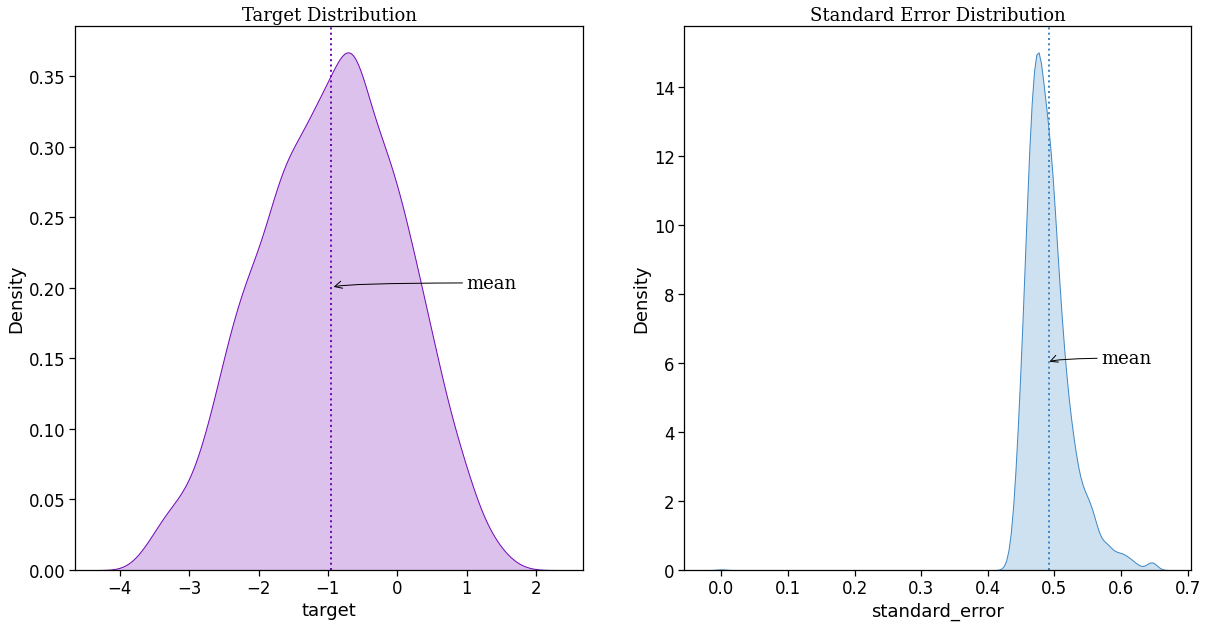

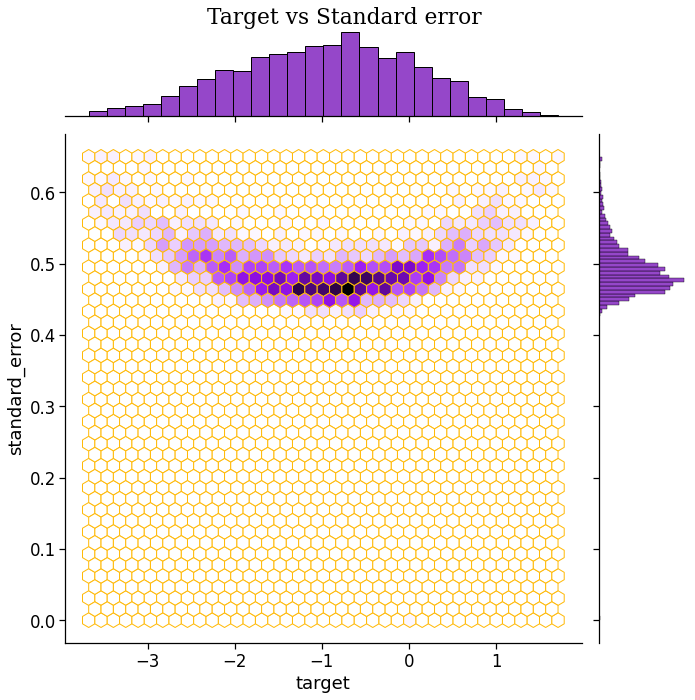

In [14]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
sns.kdeplot(train_df['target'], color=palette[0], shade=True,ax=ax[0])
sns.kdeplot(train_df['standard_error'], color=palette[1], shade=True,ax=ax[1])
ax[0].axvline(train_df['target'].mean(), color=palette[0],linestyle=':', linewidth=2)
ax[1].axvline(train_df['standard_error'].mean(), color=palette[1],linestyle=':', linewidth=2)
ax[0].set_title("Target Distribution",font="Serif")
ax[1].set_title("Standard Error Distribution",font="Serif")
ax[0].annotate('mean', xy=(-0.3* np.pi, 0.2), xytext=(1, 0.2), font='Serif',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle3,angleA=0,angleB=-90"));
ax[1].annotate('mean', xy=(0.49, 6), xytext=(0.57, 6), font='Serif',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle3,angleA=0,angleB=-90"));
plt.show()

sns.jointplot(x=train_df['target'], y=train_df['standard_error'], kind='hex',height=10,edgecolor=palette[4])
plt.suptitle("Target vs Standard error ",font="Serif")
plt.subplots_adjust(top=0.95)
plt.show()

Logging **custom histograms** for target and standard error distribution 🏋️‍♀️

In [15]:
plot_wb_hist(train_df,"target","Target Distribution")
plot_wb_hist(train_df,"standard_error","Standard Error Distribution")

Logging a **dictionary of custom objects** 🏋️‍♀️

In [16]:
run = wandb.init(project='commonlit', name='count')

# maximum target
m_t = train_df["target"].max() 

# minimum target
l_t = train_df["target"].min() 

# maximum standard error
m_se = train_df["standard_error"].max()

# minimum standard error
l_se = train_df["standard_error"].min() 

wandb.log({'Target (highest value)': m_t, 
           'Target (lowest value)': l_t,
           'Standard error (highest value)': m_se, 
           'Standard error (lowest value)': l_se
          })

run.finish()

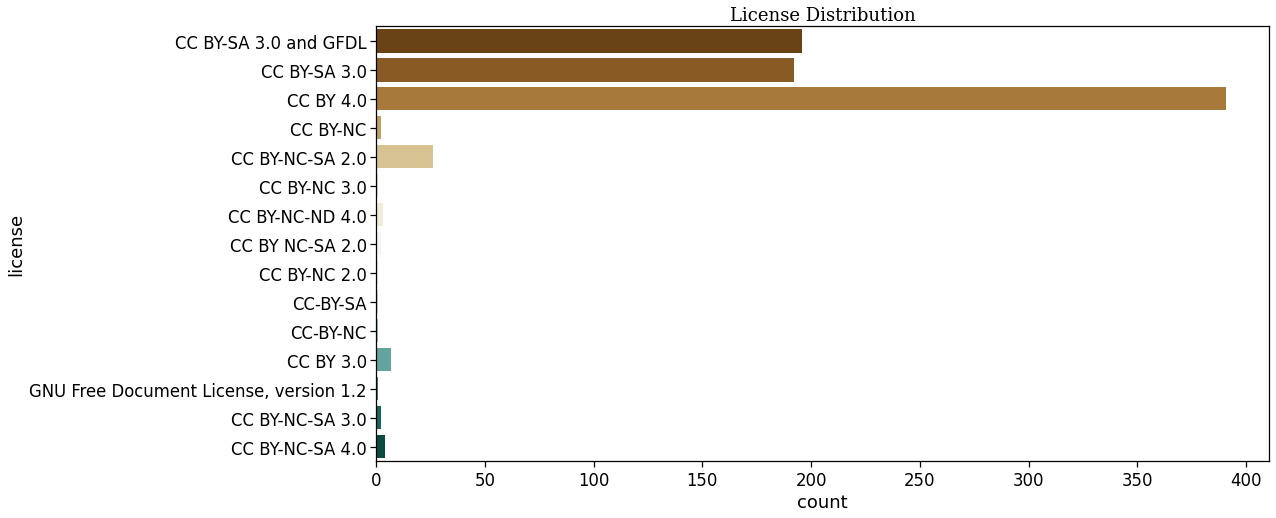

In [17]:
plt.figure(figsize=(16, 8))
sns.countplot(y="license",data=train_df,palette="BrBG",linewidth=3)
plt.title("License Distribution",font="Serif")
plt.show()

Logging a **custom bar chart** for license distribution 🏋️‍♀️

In [18]:
license_data = pd.DataFrame(train_df.license.value_counts().reset_index().values,columns=["license", "counts"])
plot_wb_bar(license_data,'license', 'counts',"license","License Distribution")

In [19]:
def get_top_n_words(corpus, n=None):
    vec = CV().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_n_bigram(corpus, n=None):
    vec = CV(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


def get_top_n_trigram(corpus, n=None):
    vec = CV(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [20]:
def plot_bt(x,w,p):
    common_words = x(train_df['excerpt_preprocessed'], 20)
    common_words_df = DataFrame (common_words,columns=['word','freq'])

    plt.figure(figsize=(16,8))
    sns.barplot(x='freq', y='word', data=common_words_df,facecolor=(0, 0, 0, 0),linewidth=3,edgecolor=sns.color_palette(p,20))
    plt.title("Top 20 "+ w,font='Serif')
    plt.xlabel("Frequency", fontsize=14)
    plt.yticks(fontsize=13)
    plt.xticks(rotation=45, fontsize=13)
    plt.ylabel("");
    return common_words_df

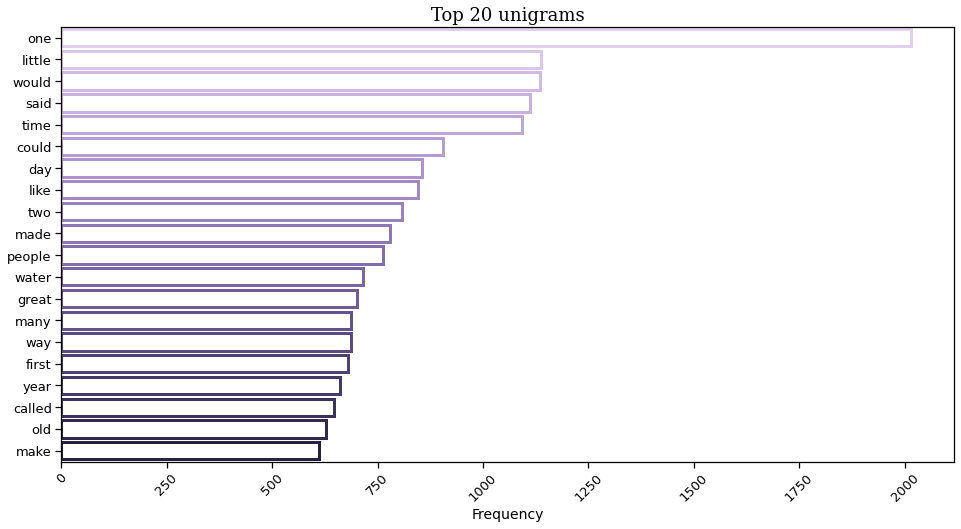

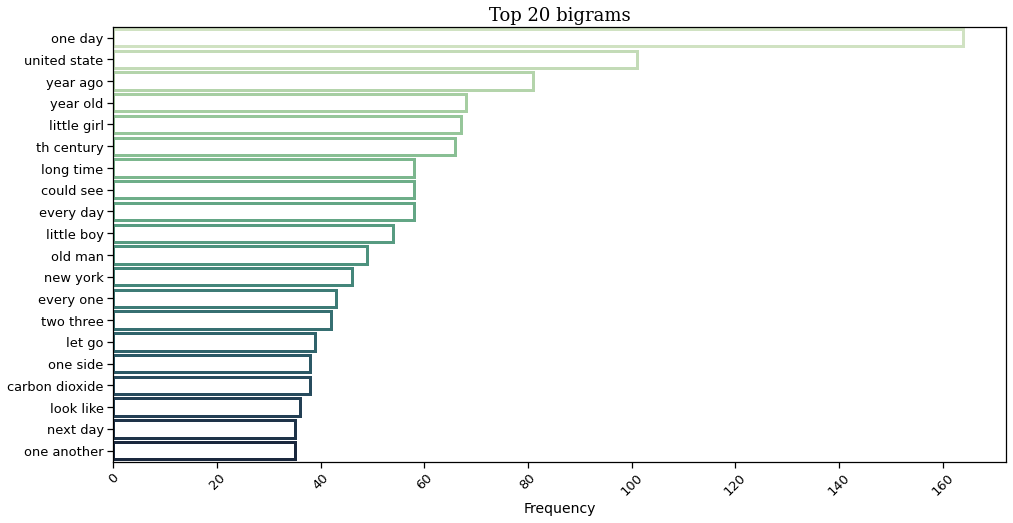

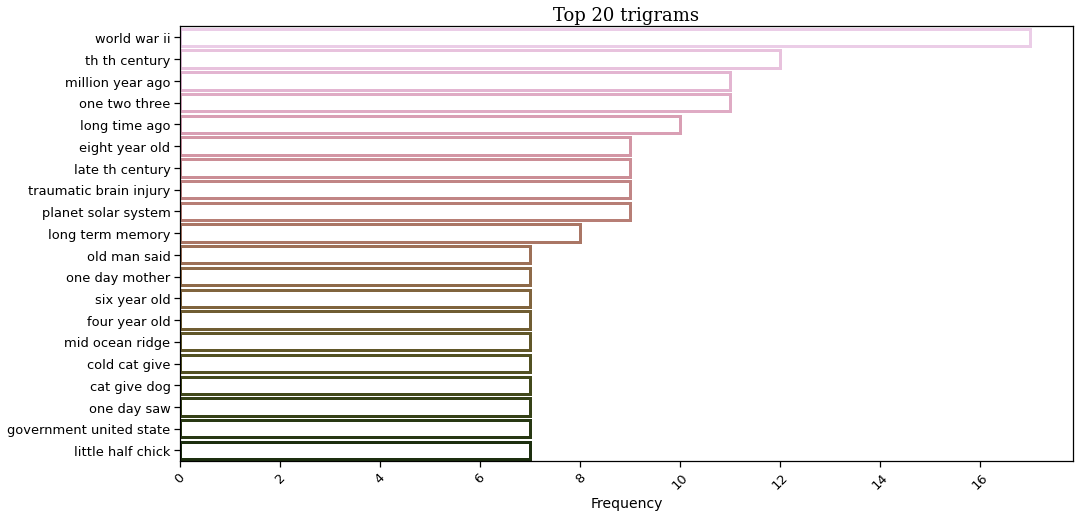

In [21]:
common_words = get_top_n_words(train_df['excerpt_preprocessed'], 20)
common_words_df1 = DataFrame(common_words,columns=['word','freq'])
plt.figure(figsize=(16, 8))
ax = sns.barplot(x='freq', y='word', data=common_words_df1,facecolor=(0, 0, 0, 0),linewidth=3,edgecolor=sns.color_palette("ch:start=3, rot=.1",20))

plt.title("Top 20 unigrams",font='Serif')
plt.xlabel("Frequency", fontsize=14)
plt.yticks(fontsize=13)
plt.xticks(rotation=45, fontsize=13)
plt.ylabel("");

common_words_df2 = plot_bt(get_top_n_bigram,"bigrams","ch:rot=-.5")
common_words_df3 = plot_bt(get_top_n_trigram,"trigrams","ch:start=-1, rot=-.6")

Logging **custom bar charts** for unigrams, bigrams and trigrams 🏋️‍♀️

In [22]:
plot_wb_bar(common_words_df1,'word','freq',"unigrams","Top 20 unigrams")
plot_wb_bar(common_words_df2,'word','freq',"bigrams","Top 20 bigrams")
plot_wb_bar(common_words_df3,'word','freq',"trigrams","Top 20 trigrams")

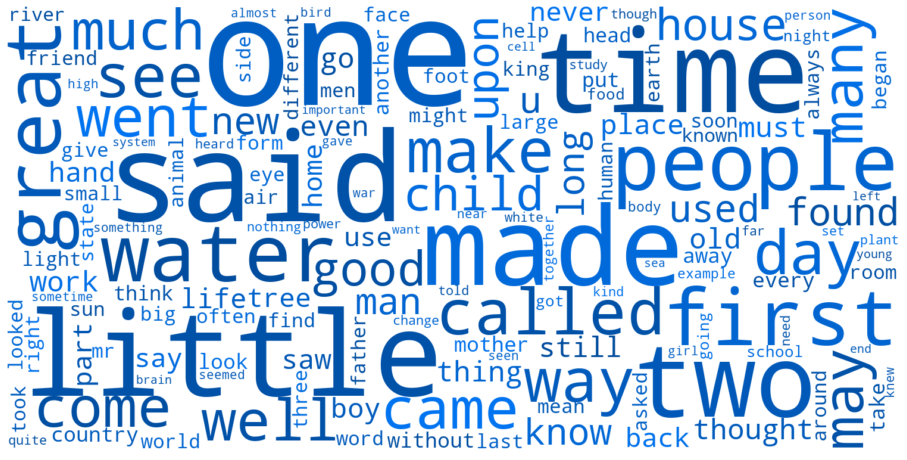

In [23]:
# color function for the wordcloud
def color_wc(word=None,font_size=None,position=None, orientation=None,font_path=None, random_state=None):
    h = int(360.0 * 150.0 / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(80, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

plt.subplots(figsize=(16,16))
wc = WordCloud(stopwords=STOPWORDS,background_color="white", contour_width=2, contour_color='blue',width=1500, height=750,color_func=color_wc,max_words=150, max_font_size=256,random_state=42)
wc.generate(' '.join(train_df['excerpt_preprocessed']))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

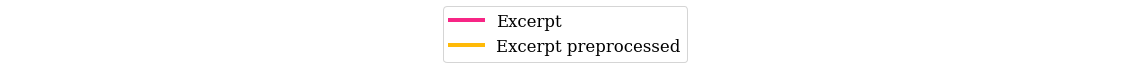

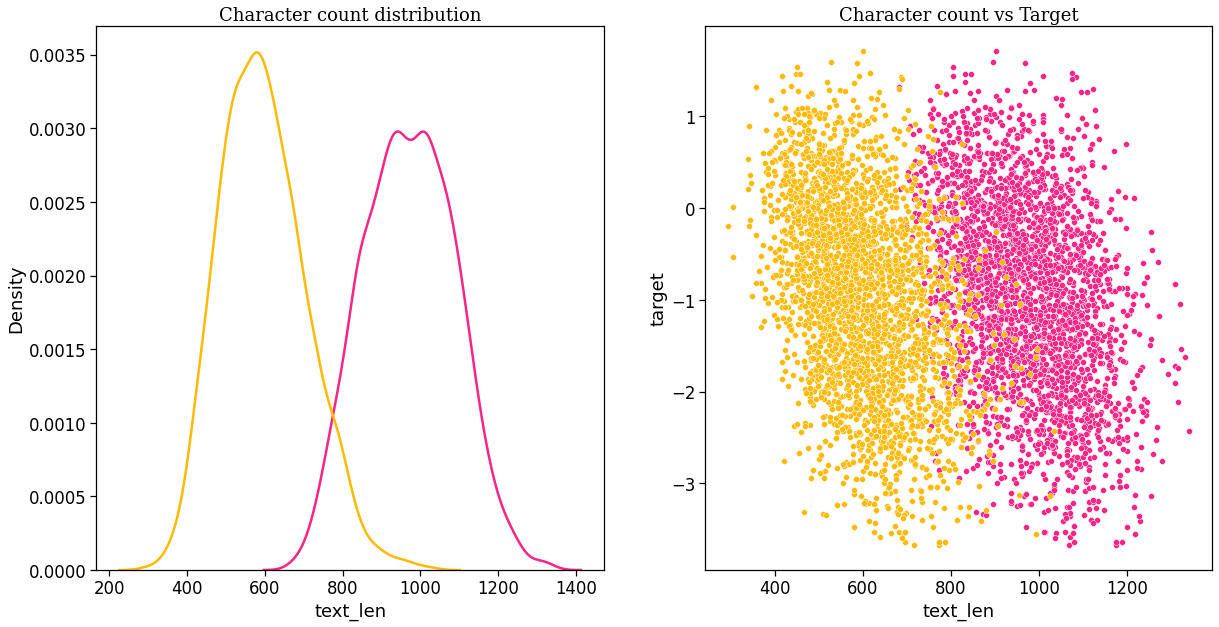

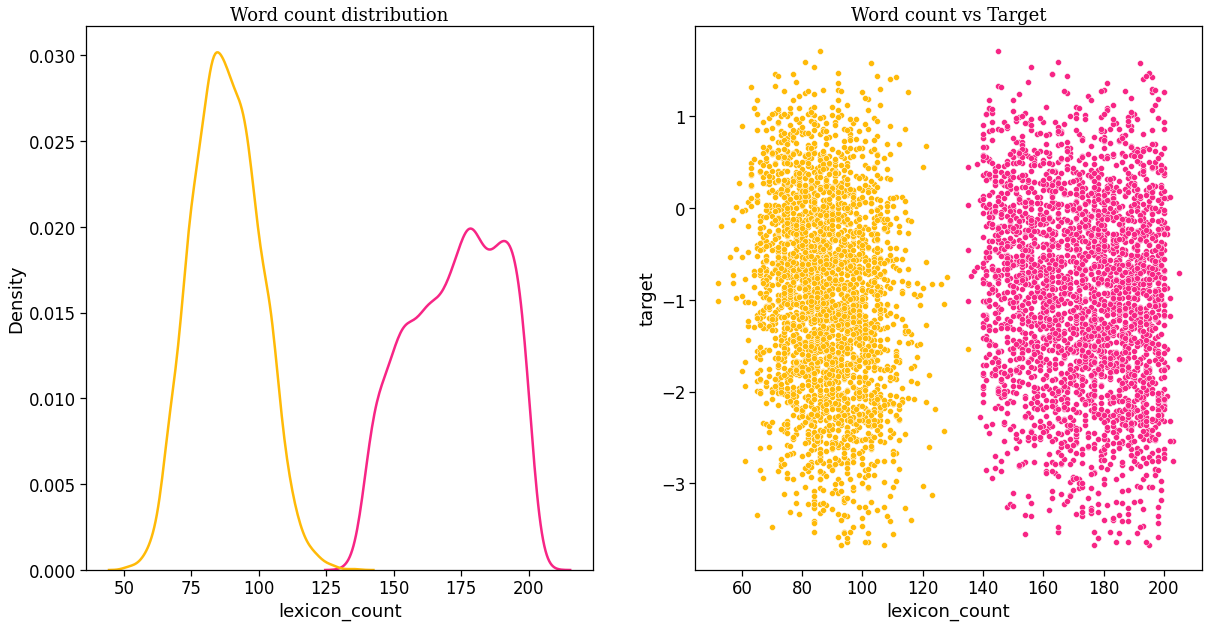

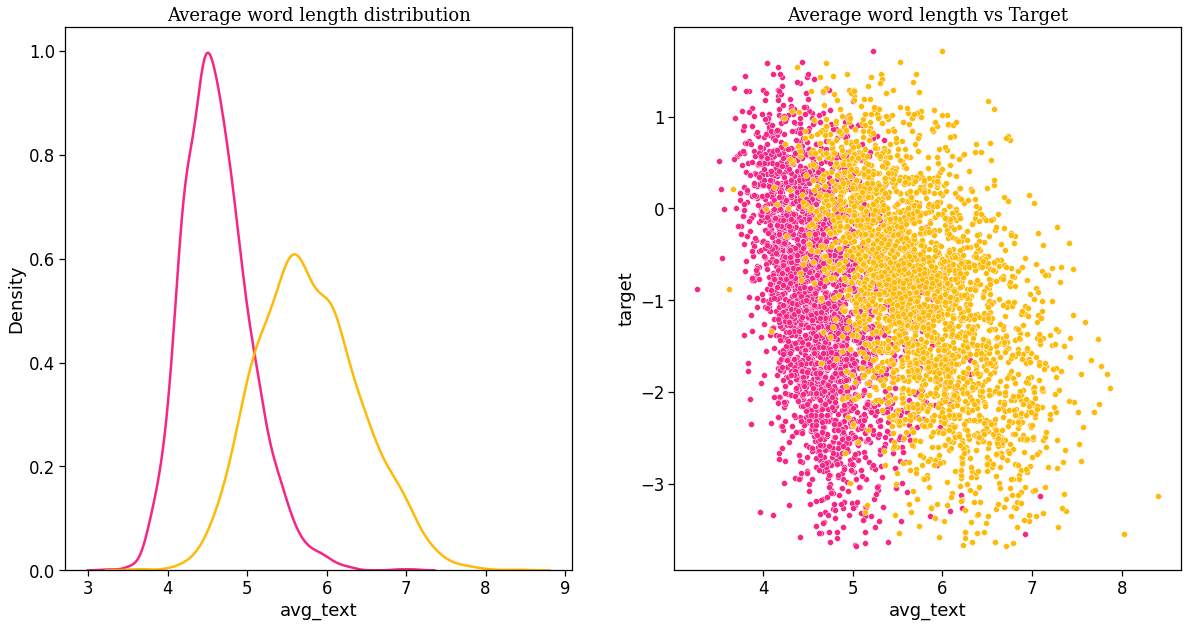

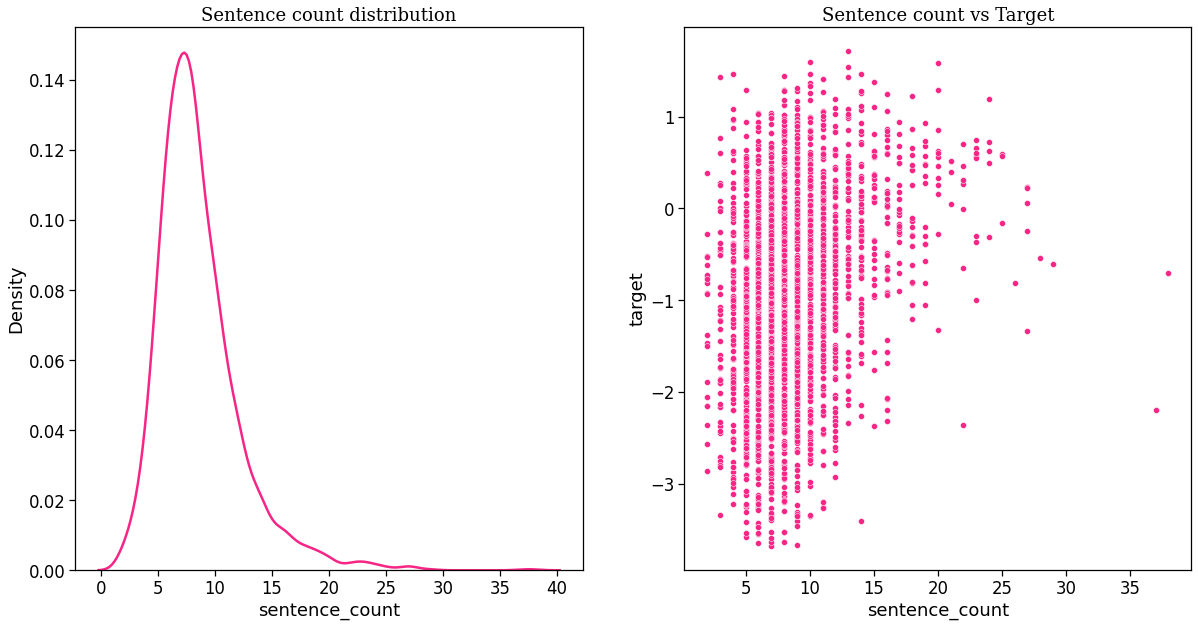

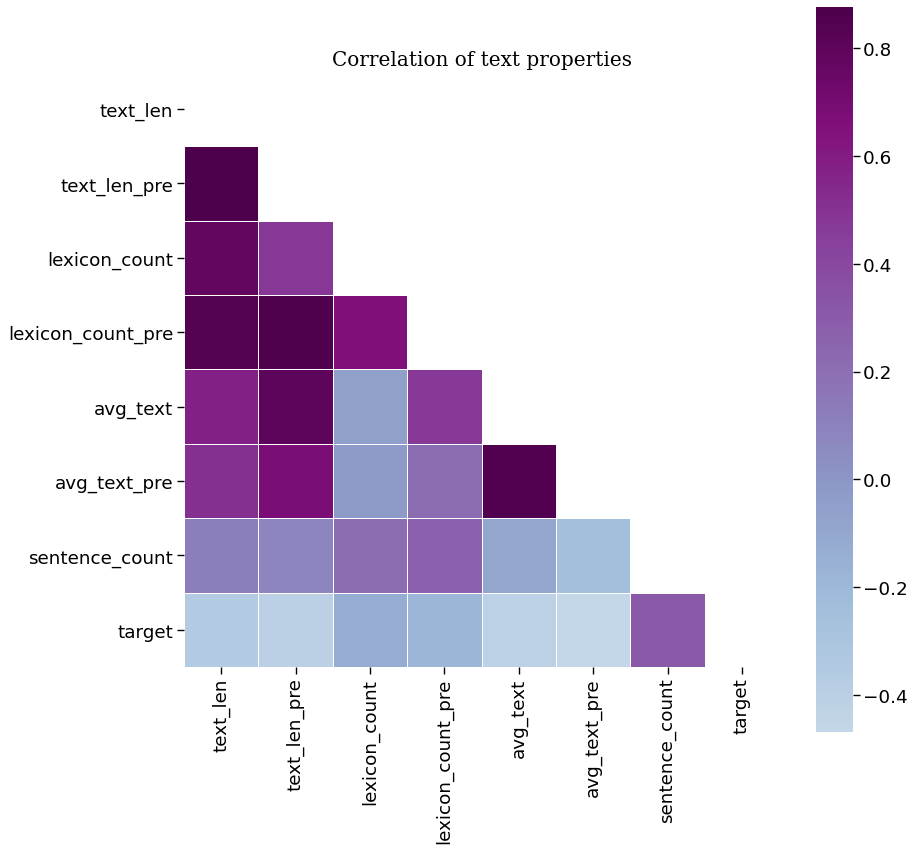

In [24]:
text_props = train_df.copy()

def avg_word_len(df):
    df = df.str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))
    return df

text_len = train_df['excerpt'].str.len()
text_len_pre = train_df['excerpt_preprocessed'].str.len()
avg_text = avg_word_len(train_df['excerpt'])
avg_text_pre = avg_word_len(train_df['excerpt_preprocessed'])
lexicon_count = []
lexicon_count_pre = []
sentence_count = []
for i in range(len(train_df)):
    lc = textstat.lexicon_count(train_df['excerpt'][i])
    lcp = textstat.lexicon_count(train_df['excerpt_preprocessed'][i])
    sc = textstat.sentence_count(train_df['excerpt'][i])
    lexicon_count.append(lc)
    lexicon_count_pre.append(lcp)
    sentence_count.append(sc)
    
text_props['text_len'] = text_len
text_props['text_len_pre'] = text_len_pre
text_props['lexicon_count'] = lexicon_count
text_props['lexicon_count_pre'] = lexicon_count_pre
text_props['avg_text'] = avg_text
text_props['avg_text_pre'] = avg_text_pre
text_props['sentence_count'] = sentence_count

def plot_distribution(col1,col2,title1,title2):
    fig, ax = plt.subplots(1,2,figsize=(20,10))
    sns.kdeplot(data=text_props, x=col1,color=palette[3],label="Excerpt",ax=ax[0])
    sns.kdeplot(data=text_props, x=col2,color=palette[4],label="Excerpt preprocessed",ax=ax[0])
    ax[0].set_title(title1,font="Serif")

    sns.scatterplot(data=text_props,x=col1,y='target',color= palette[3],ax=ax[1],markers='.')
    sns.scatterplot(data=text_props,x=col2,y='target',color= palette[4],ax=ax[1],markers='.')
    ax[1].set_title(title2,font="Serif")

    plt.show()

custom_lines = [Line2D([0], [0], color=palette[3], lw=4),
                Line2D([0], [0], color=palette[4], lw=4)]

plt.figure(figsize=(20, 1))
legend = plt.legend(custom_lines, ['Excerpt', 'Excerpt preprocessed'],loc="center")
plt.setp(legend.texts, family='Serif')
plt.axis('off')
plt.show()

plot_distribution("text_len","text_len_pre","Character count distribution","Character count vs Target")
plot_distribution("lexicon_count","lexicon_count_pre","Word count distribution","Word count vs Target")
plot_distribution("avg_text","avg_text_pre", "Average word length distribution","Average word length vs Target")

fig, ax = plt.subplots(1,2,figsize=(20,10))
sns.kdeplot(data=text_props, x=sentence_count,color=palette[3],label="Excerpt",ax=ax[0])
ax[0].set_title("Sentence count distribution",font="Serif")
ax[0].set_xlabel("sentence_count")
sns.scatterplot(data=text_props,x='sentence_count',y='target',color= palette[3],ax=ax[1],markers='.')
ax[1].set_title("Sentence count vs Target",font="Serif")
plt.show()

num_cols = ['text_len','text_len_pre','lexicon_count','lexicon_count_pre','avg_text','avg_text_pre','sentence_count','target']
corr = text_props[num_cols].corr()

fig = plt.figure(figsize=(12,12),dpi=80)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='BuPu', robust=True, center=0,
            square=True, linewidths=.5)
plt.title('Correlation of text properties', fontsize=15,font="Serif")
plt.show()

📌 ```sentence_count``` and ```target``` are very highly correlated since extremely long sentences can be complex to read and understand.

Logging **custom histograms** for the distribution of character count, word count, average word length and sentence count 🏋️‍♀️

In [25]:
plot_wb_hist(text_props,"text_len","Character Count Distribution")
plot_wb_hist(text_props,"lexicon_count","Word Count Distribution")
plot_wb_hist(text_props,"avg_text","Average Word Length Distribution")
plot_wb_hist(text_props,"sentence_count","Sentence Count Distribution")

# Part-of-Speech tagging 🏷️

In [26]:
text_props['pos_tags'] = text_props['excerpt_preprocessed'].str.split().map(pos_tag)

def count_tags(pos_tags):
    tag_count = {}
    for word,tag in pos_tags:
        if tag in tag_count:
            tag_count[tag] += 1
        else:
            tag_count[tag] = 1
    return tag_count

text_props['tag_counts'] = text_props['pos_tags'].map(count_tags)

In [27]:
set_pos = set([tag for tags in text_props['tag_counts'] for tag in tags])
tag_cols = list(set_pos)

for tag in tag_cols:
    text_props[tag] = text_props['tag_counts'].map(lambda x: x.get(tag, 0))

| Abbreviation    | Meaning                                              |
|-----------------|------------------------------------------------------|
| CC              | coordinating conjunction                             |
| CD              | cardinal digit                                       |
| DT              | determiner                                           |
| EX              | existential there                                    |
| FW              | foreign word                                         |
| IN              | preposition/subordinating conjunction                |
| JJ              | adjective (large)                                    |
| JJR             | adjective, comparative (larger)                      |
| JJS             | adjective, superlative (largest)                     |
| LS              | list item marker                                     |
| MD              | modal (could, will)                                  |
| NN              | noun, singular                                       |
| NNS             | noun plural                                          |
| NNP             | proper noun, singular                                |
| NNPS            | proper noun, plural                                  |
| PDT             | predeterminer                                        |
| POS             | possessive ending (parent\ 's)                       |
| PRP             | personal pronoun (hers, herself, him,himself)        |
| PRP dollar-sign | possessive pronoun (her, his, mine, my, our )        |
| RB              | adverb (occasionally, swiftly)                       |
| RBR             | adverb, comparative (greater)                        |
| RBS             | adverb, superlative (biggest)                        |
| RP              | particle (about)                                     |
| SYM             | symbol                                               |
| TO              | infinite marker (to)                                 |
| UH              | interjection (goodbye)                               |
| VB              | verb (ask)                                           |
| VBG             | verb gerund (judging)                                |
| VBD             | verb past tense (pleaded)                            |
| VBN             | verb past participle (reunified)                     |
| VBP             | verb, present tense not 3rd person singular(wrap)    |
| VBZ             | verb, present tense with 3rd person singular (bases) |
| WDT             | wh-determiner (that, what)                           |
| WP              | wh- pronoun (who)                                    |
| WP dollar-sign  | possessive wh-pronoun                                |
| WRB             | wh- adverb (how)                                     |

📌 Higher the grade, more the complexity of grammar(?)

[Penn Part of Speech Tags](https://cs.nyu.edu/~grishman/jet/guide/PennPOS.html)

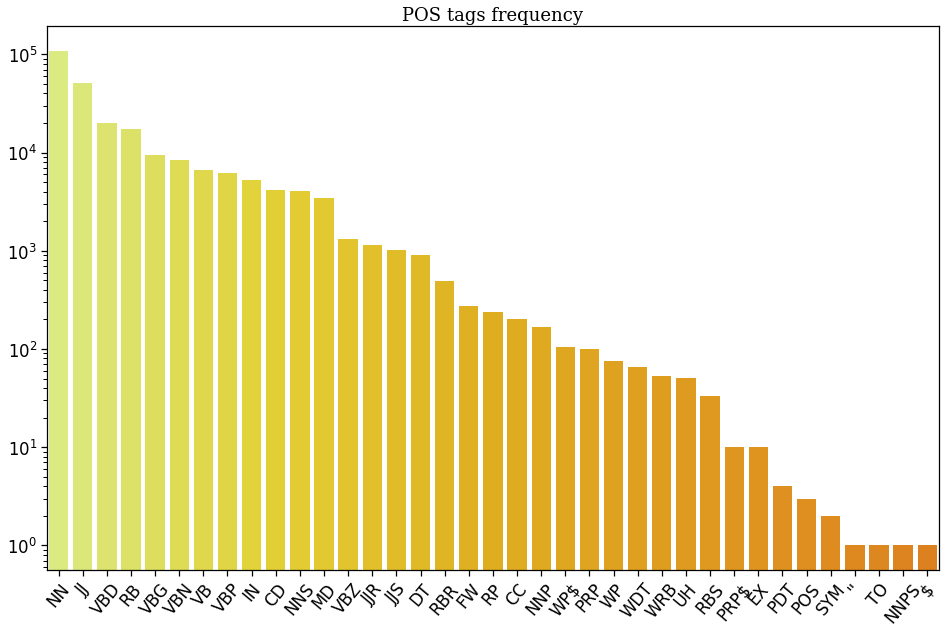

In [28]:
pos = text_props[tag_cols].sum().sort_values(ascending = False)
plt.figure(figsize=(16,10))
ax = sns.barplot(x=pos.index, y=pos.values,palette="Wistia")
plt.xticks(rotation = 50)
ax.set_yscale('log')
plt.title('POS tags frequency',fontsize=15,font="Serif")
plt.show()

Logging a **custom bar chart** for POS distribution 🏋️‍♀️

In [29]:
pos_data = pd.DataFrame({'part_of_speech':pos.index, 'freq':pos.values})
plot_wb_bar(pos_data,'part_of_speech', 'freq',"POS","POS tags frequency")

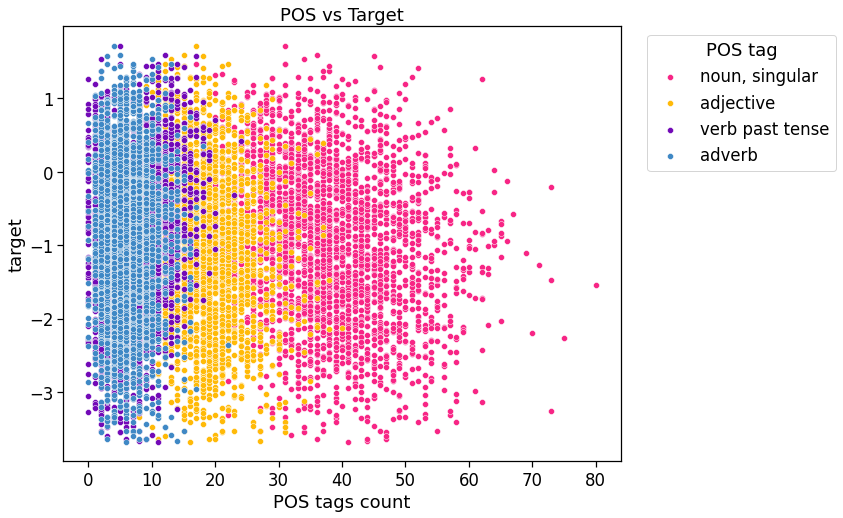

In [30]:
plt.figure(figsize=(10,8))
sns.scatterplot(data=text_props,x='NN',y='target',color= palette[3],markers='.',label="noun, singular")
sns.scatterplot(data=text_props,x='JJ',y='target',color= palette[4],markers='.',label="adjective",)
sns.scatterplot(data=text_props,x='VBD',y='target',color= palette[0],markers='.',label="verb past tense")
sns.scatterplot(data=text_props,x='RB',y='target',color= palette[1],markers='.',label="adverb")
plt.legend(title="POS tag",bbox_to_anchor=(1.4, 1))
plt.xlabel("POS tags count")
plt.title("POS vs Target")
plt.show()

In [31]:
toughest_excerpt = text_props[text_props["target"] == text_props["target"].min()].excerpt.values[0]
lowest_target = text_props[text_props["target"] == text_props["target"].min()].target.values[0]
nlp = spacy.load("en_core_web_sm")
sentences = sent_tokenize(toughest_excerpt)
word_count = lambda sentence: len(word_tokenize(sentence))
pos_text = max(sentences, key=word_count)  

console.print("Target of the toughest excerpt: ",style="info")
console.print(lowest_target,style='warning')

console.print("Longest sentence of the toughest excerpt: ",style="info")

Target of the toughest excerpt: 

-3.676267773

Longest sentence of the toughest excerpt: 

In [32]:
doc = nlp(pos_text)
displacy.render(doc, style="dep")

# Readability tests 🧪

[textstat](https://pypi.org/project/textstat/) is a library used to calculate statistics from text.
It came in super handy for calculating scores of various readability tests!

- ```flesch_re:``` [The Flesch Reading Ease formula](https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests#Flesch_reading_ease)
- ```flesch_kg:``` [The Flesch-Kincaid Grade Level ](https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests#Flesch_reading_ease)
- ```fog_scale:``` [The Fog Scale (Gunning FOG Formula)](https://en.wikipedia.org/wiki/Gunning_fog_index)
- ```automated_r:``` [Automated Readability Index](https://en.wikipedia.org/wiki/Automated_readability_index)
- ```coleman:``` [The Coleman-Liau Index](https://en.wikipedia.org/wiki/Coleman%E2%80%93Liau_index)
- ```linsear:``` [Linsear Write Formula](https://en.wikipedia.org/wiki/Linsear_Write)
- ```text_standard:``` Readability Consensus based upon all the above tests

In [33]:
# flesch_re, flesch_kg, fog_scale, automated_r,coleman, linsear, text_standard  = ([] for i in range(7))
# for i in range(len(text_props)):
#     flr = textstat.flesch_reading_ease(train_df['excerpt'][i])
#     flkg = textstat.flesch_kincaid_grade(train_df['excerpt'][i])
#     fs = textstat.gunning_fog(train_df['excerpt'][i])
#     ar = textstat.automated_readability_index(train_df['excerpt'][i])
#     cole = textstat.coleman_liau_index(train_df['excerpt'][i])
#     lins = textstat.linsear_write_formula(train_df['excerpt'][i])
#     ts = textstat.text_standard(train_df['excerpt'][i])
    
#     flesch_re.append(flr)
#     flesch_kg.append(flkg)
#     fog_scale.append(fs)
#     automated_r.append(ar)
#     coleman.append(cole)
#     linsear.append(lins)
#     text_standard.append(ts)
    
# text_props['flesch_re'] = flesch_re
# text_props['flesch_kg'] = flesch_kg
# text_props['fog_scale'] = fog_scale
# text_props['automated_r'] = automated_r
# text_props['coleman'] = coleman
# text_props['linsear'] = linsear
# text_props['text_standard'] = text_standard

Logging the text properties dataset as an **artifact** 🏋️‍♀️

This helps me to save on time since I can directly use the saved artifact for my workflow 🥳

In [34]:
# #====== Saving to csv files and creating artifacts ======
# text_props.to_csv("text_props_readability.csv")

# run = wandb.init(project='commonlit', name='text_props_readability')

# artifact = wandb.Artifact('text_props_readability', type='dataset')

# #====== Add a file to the artifact's contents ======
# artifact.add_file("text_props_readability.csv")

# #====== Save the artifact version to W&B and mark it as the output of this run ====== 
# run.log_artifact(artifact)

# run.finish()

A snapshot of the newly created artifacts ⬇️

<img src="https://i.imgur.com/WFeQRt7.png">

Since I have already logged the artifact, I can directly use it in this manner ⬇️

In [35]:
run = wandb.init(project='commonlit')
artifact = run.use_artifact('ruchi798/commonlit/text_props_readability:v0', type='dataset')
artifact_dir = artifact.download()
run.finish()

path = os.path.join(artifact_dir,"text_props_readability.csv")
text_props = pd.read_csv(path)
text_props = text_props.drop(columns=["Unnamed: 0"])

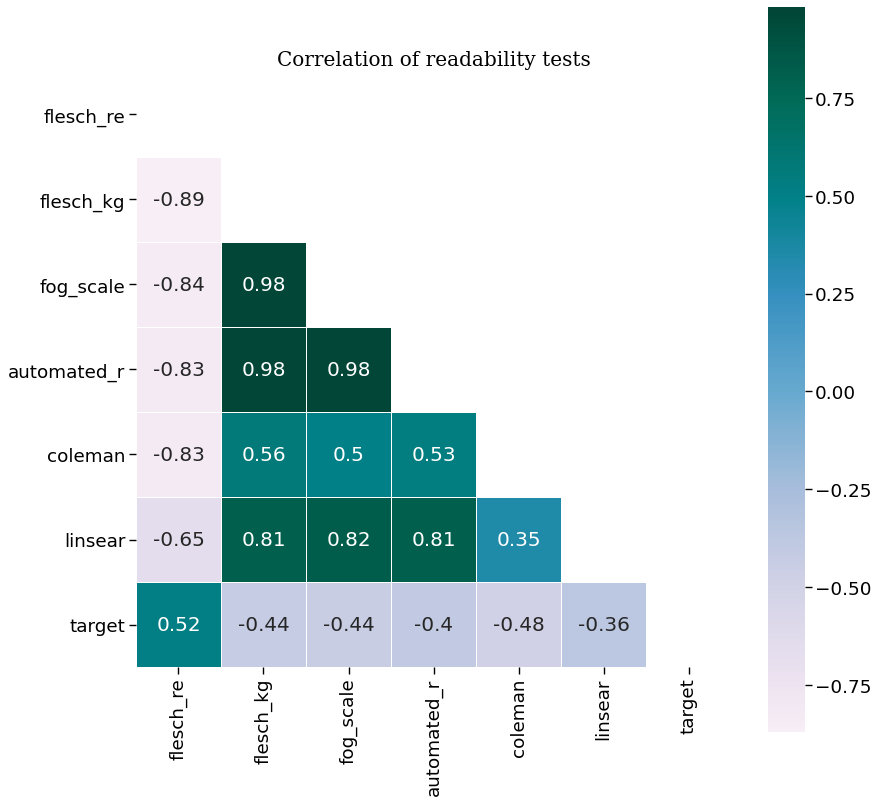

In [36]:
readability_cols = ['flesch_re','flesch_kg','fog_scale','automated_r','coleman','linsear','text_standard','target']

corr = text_props[readability_cols].corr()
fig = plt.figure(figsize=(12,12),dpi=80)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='PuBuGn', robust=True, center=0,
            square=True, linewidths=.5,annot=True)
plt.title('Correlation of readability tests', fontsize=15,font="Serif")
plt.show()

There is a strong correlation between our ```target``` variable and the ```Flesch Readability Ease``` test values.

Let's explore the distribution of test values for ```Flesch Readability Ease```.

| Score          | Notes                                                                  |
|----------------|------------------------------------------------------------------------|
| 90-100         | very easy to read, easily understood by an average 11-year-old student |
| 80-90          | easy to read                                                           |
| 70-80          | fairly easy to read                                                    |
| 60-70          | easily understood by 13- to 15-year-old students                       |
| 50-60          | fairly difficult to read                                               |
| 30-50          | difficult to read, best understood by college graduates                |
| 0-30           | very difficult to read, best understood by university graduates        |

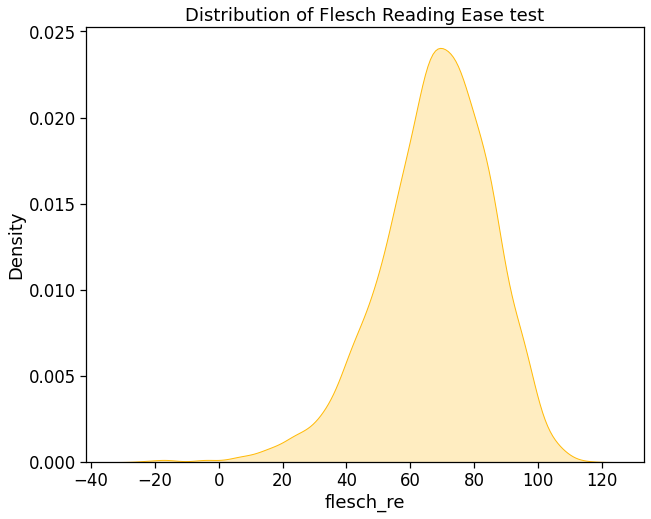

In [37]:
plt.figure(figsize=(10,8))
sns.kdeplot(text_props["flesch_re"],color=palette[4],shade=True)
plt.title("Distribution of Flesch Reading Ease test")
plt.show()

Logging a **custom histogram** for the distribution of Flesch Reading Ease scores 🏋️‍♀️

In [38]:
plot_wb_hist(text_props,"flesch_re","Flesch Reading Ease Distribution")

📌 More than **70%** of excerpts can be easily understood by **13-15 year olds**.

In [39]:
text_props.loc[text_props['flesch_re'] > 60]['flesch_re'].count() / len(text_props) *100

70.39520112914607

Let's see which excerpts have the highest and lowest ```Target``` and ```Flesch Reading Ease Score``` ⬇️

In [40]:
pd.set_option('display.max_colwidth', None)
max_text = text_props[text_props["target"] == text_props["target"].max()]['excerpt']
min_text = text_props[text_props["target"] == text_props["target"].min()]['excerpt']

max_text_f = text_props[text_props["flesch_re"] == text_props["flesch_re"].max()]['excerpt']
min_text_f = text_props[text_props["flesch_re"] == text_props["flesch_re"].min()]['excerpt']

console.print("Highest Target", style="danger")
console.print(max_text, style="info")
text_props[text_props["target"] == text_props["target"].max()][['flesch_re','target','text_standard']]

Highest Target

2829    When you think of dinosaurs and where they lived, what do you picture? Do you see 
hot, steamy swamps, thick jungles, or sunny plains? Dinosaurs lived in those places, yes. But
did you know that some dinosaurs lived in the cold and the darkness near the North and South 
Poles?\nThis surprised scientists, too. Paleontologists used to believe that dinosaurs lived 
only in the warmest parts of the world. They thought that dinosaurs could only have lived in 
places where turtles, crocodiles, and snakes live today. Later, these dinosaur scientists 
began finding bones in surprising places.\nOne of those surprising fossil beds is a place 
called Dinosaur Cove, Australia. One hundred million years ago, Australia was connected to 
Antarctica. Both continents were located near the South Pole. Today, paleontologists dig 
dinosaur fossils out of the ground. They think about what those ancient bones must mean.
Name: excerpt, dtype: object

,flesch_re,target,text_standard
2829,77.03,1.71139,6th and 7th grade


In [41]:
console.print("Highest Flesch Reading Ease Score", style="danger")
console.print(max_text_f, style="info")
text_props[text_props["flesch_re"] == text_props["flesch_re"].max()][['flesch_re','target','text_standard']]

Highest Flesch Reading Ease Score

1532    A little pine tree was in the woods.\nIt had no leaves. It had needles.\nThe little 
tree said, "I do not like needles. All the other trees in the woods have pretty leaves. I 
want leaves, too. But I will have better leaves. I want gold leaves."\nNight came and the 
little tree went to sleep. A fairy came by and gave it gold leaves.\nWhen the little tree 
woke it had leaves of gold.\nIt said, "Oh, I am so pretty! No other tree has gold 
leaves."\nNight came.\nA man came by with a bag. He saw the gold leaves. He took them all and
put them into his bag.\nThe poor little tree cried, "I do not want gold leaves again. I will 
have glass leaves."\nSo the little tree went to sleep. The fairy came by and put the glass 
leaves on it.\nThe little tree woke and saw its glass leaves.\nHow pretty they looked in the 
sunshine! 'No other tree was so bright.\nThen a wind came up. It blew and blew.\nThe glass 
leaves all fell from the tree and were broken.
Name: excerpt, dtype: object

,flesch_re,target,text_standard
1532,114.52,0.56648,2nd and 3rd grade


In [42]:
console.print("Lowest Target", style="danger")
console.print(min_text, style="warning")
text_props[text_props["target"] == text_props["target"].min()][['flesch_re','target','text_standard']]

Lowest Target

1705    The commutator is peculiar, consisting of only three segments of a copper ring, while
in the simplest of other continuous current generators several times that number exist, and 
frequently 120! segments are to be found. These three segments are made so as to be removable
in a moment for cleaning or replacement. They are mounted upon a metal support, and are 
surrounded on all sides by a free air space, and cannot, therefore, lose their insulated 
condition. This feature of air insulation is peculiar to this system, and is very important 
as a factor in the durability of the commutator. Besides this, the commutator is sustained by
supports carried in flanges upon the shaft, which flanges, as an additional safeguard, are 
coated all over with hard rubber, one of the finest known insulators. It may be stated, 
without fear of contradiction, that no other commutator made is so thoroughly insulated and 
protected. The three commutator segments virtually constitute a single copper ring, mounted 
in free air, and cut into three equal pieces by slots across its face.
Name: excerpt, dtype: object

,flesch_re,target,text_standard
1705,45.8,-3.676268,14th and 15th grade


In [43]:
console.print("Lowest Flesch Reading Ease Score", style="danger")
console.print(min_text_f, style="warning")
text_props[text_props["flesch_re"] == text_props["flesch_re"].min()][['flesch_re','target','text_standard']]

Lowest Flesch Reading Ease Score

1167    The principal subjects, concerning which President Wilson and I were in marked 
disagreement, were the following: His presence in Paris during the peace negotiations and 
especially his presence there as a delegate to the Peace Conference; the fundamental 
principles of the constitution and functions of a League of Nations as proposed or advocated 
by him; the form of the organic act, known as the "Covenant," its elaborate character and its
inclusion in the treaty restoring a state of peace; the treaty of defensive alliance with 
France; the necessity for a definite program which the American Commissioners could follow in
carrying on the negotiations; the employment of private interviews and confidential 
agreements in reaching settlements, a practice which gave color to the charge of "secret 
diplomacy"; and, lastly, the admission of the Japanese claims to possession of German treaty 
rights at Kiao-Chau and in the Province of Shantung.\nOf these seven subjects of difference 
the most important were those relating to the League of Nations and the Covenant, though our 
opposite views as to Shantung were more generally known and more frequently the subject of 
public comment.
Name: excerpt, dtype: object

,flesch_re,target,text_standard
1167,-22.93,-2.563458,12th and 13th grade


# Baseline model ⚙️

In [44]:
def training(model, X_train, y_train, X_test, y_test, model_name):
    t1 = time.time()
    
    model = make_pipeline(
        TfidfVectorizer(binary=True, ngram_range=(1,1)),
        model,
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    MSE = mse(y_test, y_pred)
    
    t2 = time.time()
    training_time = t2-t1 
    
    console.print("--- Model:", model_name,"---",style='warning')
    console.print("MSE: ",MSE,style='danger')
    console.print("Training time:",training_time,style='danger')

ridge = Ridge(fit_intercept = True, normalize = False)
lr = LinearRegression()
m = [ridge,lr]
mn = ["Ridge Regression","Linear Regression"]

X = train_df["excerpt_preprocessed"]
y = train_df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

for i in range(0,len(m)):
    training(model=m[i], X_train=X_train, y_train=y_train, X_test=X_test,y_test=y_test, model_name=mn[i])

--- Model: Ridge Regression ---

MSE:  0.5408408615292725

Training time: 0.3191189765930176

--- Model: Linear Regression ---

MSE:  0.597116306736868

Training time: 0.35312891006469727

In [45]:
def training_all(model,X,y):
    
    model = make_pipeline(
        TfidfVectorizer(binary=True, ngram_range=(1,1)),
        model,
    )
    model.fit(X, y)
    y_pred = model.predict(test_df["excerpt_preprocessed"])
    
    return y_pred

# Submission file 📝

In [46]:
test_pred = training_all(lr,X,y)
predictions = pd.DataFrame()
predictions['id'] = test_df['id']
predictions['target'] = test_pred
predictions.to_csv("/kaggle/working/submission.csv", index=False)
predictions

,id,target
0,c0f722661,-1.321194
1,f0953f0a5,-0.620439
2,0df072751,-0.542019
3,04caf4e0c,-2.311644
4,0e63f8bea,-1.603932
5,12537fe78,-0.425918
6,965e592c0,-0.087885


Here's a snapshot of my [project](https://wandb.ai/ruchi798/commonlit?workspace=user-ruchi798) ⬇️

<img src="https://i.imgur.com/vmxri2T.png">

Illustrations tools ⚡

- [Canva](https://www.canva.com/) 🖌️

<img src="https://i.imgur.com/pl3FhXV.png">